# Test via point, and end point for the pushing task in the pybullet working space

In [1]:
import os, time, tqdm, sys
import torch.nn as nn
import numpy as np
import torch

# add parent dictionary to path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from models.vae import TrajGen, DM
from models.dmp import CanonicalSystem, SingleDMP
from utils.data_loader import TorqueLoader as Torque_dataset
from utils.early_stop import EarlyStop
from matplotlib import pyplot as plt
from collections import OrderedDict
print(os.getcwd())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

/home/binzhao/Documents/code/VAE_DMP_mani/manipulation_task
cuda


create cVAE-dmp model

In [2]:
# create dmp model 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
run_time = 1
dt = 0.01
# define the shape of each damonstration
shape = (5, 100)
# create dataset for training and testing
cs = CanonicalSystem(dt=0.01, ax=1)
dmp = SingleDMP(n_bfs=50, cs=cs, run_time=1.0, dt=0.01)
print("device: ", device) 

device:  cuda


In [3]:
# get max, min from dataset to de-normalize the data
train_dataset = Torque_dataset(run_time=1, dmp=dmp, dt=0.01, dof=2)
train_dataset.load_data('../data/manipulation_data/train_torque.npz', device=device)
train_dataset.torque = train_dataset.normalize_data(device=device)

#get normalize  paramters of data
max = train_dataset.max.cpu().numpy()
min = train_dataset.min.cpu().numpy()
print(max, min)

[ 9.639522 40.198143 65.1502   54.927094 89.87197 ] [-35.03298   -13.038735   -6.0426774  -4.746726  -25.30069  ]


In [4]:
# load pretrained model
save_name = "./models/cVAE_torque_manipulation.pt"
checkpoint = torch.load(save_name, map_location=device)
dict = checkpoint['net']

/tmp/ipykernel_5650/3714809421.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_name, map_location=device)


In [5]:
# load the decoder part only -- generator, label_embedding
decoder_param = OrderedDict() 
    
key_word_1 = {"decoder."}
key_word_2 = {"label_embedding."}

for layer_name, param in checkpoint["net"].items():
    for key_word in key_word_1:
        if key_word in layer_name:            
            layer_name = layer_name.replace(key_word, "")            
            decoder_param[layer_name] = param

torch.save(decoder_param, "./models/decoder.pt")

# save label encoder
label_encoder_param = OrderedDict()
for layer_name, param in checkpoint["net"].items():
    for key_word in key_word_2:
        if key_word in layer_name:            
            layer_name = layer_name.replace(key_word, "")            
            label_encoder_param[layer_name] = param

torch.save(label_encoder_param, "./models/label_encoder.pt")

In [6]:
# create trajectory generator -- decoder + dynamics system
shape = (5, 100)
nclass = 4
nhid = 8
ncond = 8

# create trajectory generator
traj_gen = TrajGen(shape=shape, nclass=nclass, nhid=nhid, ncond=ncond, min=min, max=max, device=device)
# send to device
traj_gen.decoder_o.load_state_dict(torch.load('./models/decoder.pt'))
traj_gen.decoder_n.load_state_dict(torch.load('./models/decoder.pt'))
traj_gen.label_embedding.load_state_dict(torch.load('./models/label_encoder.pt'))

/tmp/ipykernel_5650/1204908132.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  traj_gen.decoder_o.load_state_dict(torch.load('./models/decoder.pt'))
/tmp/ipykernel_5650

<All keys matched successfully>

Create pybullet based environment and load demonstration data

In [7]:
robot_model_path = "../manipulation_env/models/urdf/ur10_robotiq_85.urdf"
table_path = "../manipulation_env/models/urdf/objects/table/table.urdf"
block_path = "../manipulation_env/models/YcbPottedMeatCan/model.urdf"

demon_path = "../data/manipulation_data"

# create dictionary to store the data
demons_data = {}
for file in os.listdir(demon_path):

    if file.endswith(".npy"):
        data = np.load(os.path.join(demon_path, file), allow_pickle=True)
        task_id = int(file.split("_")[0])
        demons_data["task_id_" + str(task_id)] = data
print("Number of demonstrations: ", len(demons_data))  

# show the structure of the data
for key, value in demons_data.items():
    print(key, value.shape)

Number of demonstrations:  3
task_id_2 (33, 5)
task_id_3 (27, 5)
task_id_1 (19, 5)


In [8]:
# create pybullet environment
from manipulation_env.env import ManiEnv
from manipulation_env.robot import UR10Robotiq85
robot = UR10Robotiq85(model_path=robot_model_path)
env = ManiEnv(robot, block_path=block_path, table_path=table_path, vis=True)
env.reset()

pybullet build time: Nov 28 2023 23:51:11
0it [00:00, ?it/s]

startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Intel
GL_RENDERER=Mesa Intel(R) Graphics (RPL-P)
GL_VERSION=4.6 (Core Profile) Mesa 24.0.9-0ubuntu0.1
GL_SHADING_LANGUAGE_VERSION=4.60
pthread_getconcurrency()=0
Version = 4.6 (Core Profile) Mesa 24.0.9-0ubuntu0.1
Vendor = Intel
Renderer = Mesa Intel(R) Graphics (RPL-P)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu
b3Printf: b3Warning[examples/Imp

1it [00:01,  1.68s/it]

processing baseLink
processing baseLink


Task 2: pushing the block along the x axis:

block position: (x, y, 0.04)

via point: (x - 0.01, y, 0.04 + 0.17) # the gripper offset is 0.17

In [9]:
# get the pushing trajectory
gripper_offset = 0.17
push_demo = demons_data["task_id_2"]
block_position = np.array([0, 0, 0.04])

# relay the demon trajectory
position = push_demo[20]
block_position[0] = position[0] + 0.1
block_position[1] = position[1]
env.reset_block(pos = block_position, euler_angle=[0, 0, np.pi/2])
print("shape of push demo", push_demo.shape)

print("via-point:", push_demo[20])
print("block position", block_position)

shape of push demo (33, 5)
via-point: [ 0.46818409  0.02854814  0.22940795 -0.14041385  0.61333333]
block position [0.56818409 0.02854814 0.04      ]


Generate an initial trajectory

In [10]:
# generate trajectory from cVAE-dmp with the original end position
robot_inial_pose = push_demo[0]
robot_end_pose = push_demo[-1]
robot_end_pose[2] = robot_end_pose[2] - 0.03

robot_inial_pose = torch.tensor(robot_inial_pose, dtype=torch.float32).to(device)
robot_end_pose = torch.tensor(robot_end_pose, dtype=torch.float32).to(device)
traj_gen.eval()
with torch.no_grad():
    push_traj = traj_gen(class_idx=2, x0=robot_inial_pose, goal=robot_end_pose)

# print the generated trajectory
initial_push = push_traj.cpu().numpy()[0]

# show shape of the trajectory
print(initial_push.shape)
env.clean_traj_plot()
env.traj_plot(initial_push[:3,:].T, color=[1, 0, 0])

/home/binzhao/Documents/code/VAE_DMP_mani/models/vae.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x0).to(self.device)
/home/binzhao/Documents/code/VAE_DMP_mani/models/vae.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  goal = torch.tensor(goal).to(self.device)


(5, 100)


In [11]:
# print the end position, block position, and via-point
print("end position:", initial_push[:,-1])
print("block position:", block_position)
print("via-point:", initial_push[:,20])

end position: [ 0.67414325  0.07851585  0.18232429 -0.16922149  0.6146845 ]
block position: [0.56818409 0.02854814 0.04      ]
via-point: [0.5539152  0.05896169 0.51353276 0.06978191 0.61431736]


In [ ]:
# execute the pushing trajectory
env.reset_block(pos = block_position, euler_angle=[0, 0, np.pi/2])
env.step(initial_push[:,0])
for i in range(initial_push.shape[1]):
    env.step(initial_push[:,i])

# get block position after pushing
new_block_position = env.get_block_position()
push_dist = new_block_position[0] - block_position[0]
print("push distance: ", push_dist)

env.clean_traj_plot()
# reset the position of robot
env.reset_block(pos = block_position, euler_angle=[0, 0, np.pi/2])
env.step(push_demo[0])

the robot manipulation space:
- x: [0.3, 0.8]
- y: [-0.45, 0.45]

In [12]:
# define block position to via point mapping
def get_final_point(block_position):
    gripper_offset = 0.17
    final_point = np.zeros(5)
    final_point[0] = block_position[0] + 0.12 - 0.0369 # the block width
    final_point[1] = block_position[1]
    final_point[2] = block_position[2] + gripper_offset - 0.03 # the offset gripper length
    final_point[3] = 0
    final_point[4] = 0.61333333
    return final_point

Test block on random position with 30 trials

In [13]:
# --------------------- random block position --------------------------
# reset the environment
# store all the reaching trajectory
tractories = []
env.clean_traj_plot()
env.step(push_demo[0])

for num_traj in range(30):
    block_position = np.array([0, 0, 0.04])
    # random set the final postion of the block x- [0.5, 0.7], y- [-0.4, 0.4]
    random_x = np.random.rand() * 0.2 + 0.5
    random_y = (np.random.rand() - 0.5) * 0.8
    block_position[0] = random_x
    block_position[1] = random_y

    # reset the block position
    env.reset_block(pos = block_position, euler_angle=[0, 0, np.pi/2])
    block_pos_sim = env.get_block_position()
    # final position of end-effector
    final_position = get_final_point(block_position)
    # print("final position of end-effector: ", final_position)

    # create trajectory from cVAE-dmp
    robot_inial_pose = push_demo[0]
    robot_end_pose = final_position.copy()
    torch_inial_pose = torch.tensor(robot_inial_pose, dtype=torch.float32).to(device)
    torch_end_pose = torch.tensor(robot_end_pose, dtype=torch.float32).to(device)
    traj_gen.eval()
    with torch.no_grad():
        push_traj = traj_gen(class_idx=2, x0=torch_inial_pose, goal=torch_end_pose)
    push_data = push_traj.cpu().numpy()[0]
    env.traj_plot(push_data[:3,:].T)

    # # execute the pushing trajectory
    success = False
    env.step(robot_inial_pose)
    for i in range(push_data.shape[1]):
        env.step(push_data[:, i])
        if env.check_arrived(final_position[:3]):
            success = True
            break       
        
    # store the trajectory
    tractories.append({"traj":push_data, "success":success, "block_pose":block_pos_sim})  
    print("Trajectory: ", num_traj, "Success: ", success)  

11037it [01:34, 223.74it/s]

Trajectory:  0 Success:  True


21967it [02:24, 223.32it/s]

Trajectory:  1 Success:  True


32869it [03:14, 221.98it/s]

Trajectory:  2 Success:  True


43797it [04:04, 222.60it/s]

Trajectory:  3 Success:  True


54722it [04:54, 222.96it/s]

Trajectory:  4 Success:  True


65647it [05:44, 222.41it/s]

Trajectory:  5 Success:  True


76549it [06:34, 221.52it/s]

Trajectory:  6 Success:  True


87474it [07:24, 222.70it/s]

Trajectory:  7 Success:  True


98400it [08:14, 222.84it/s]

Trajectory:  8 Success:  True
b3Printf: b3Warning[examples/SharedMemory/PhysicsClientSharedMemory.cpp,1305]:

b3Printf: User debug draw failed


109325it [09:04, 220.78it/s]

Trajectory:  9 Success:  True


120250it [09:54, 222.62it/s]

Trajectory:  10 Success:  True


131152it [10:43, 223.37it/s]

Trajectory:  11 Success:  True


142077it [11:33, 222.47it/s]

Trajectory:  12 Success:  True


153002it [12:22, 221.09it/s]

Trajectory:  13 Success:  True


163927it [13:12, 223.41it/s]

Trajectory:  14 Success:  True


174829it [14:01, 222.90it/s]

Trajectory:  15 Success:  True


185754it [14:51, 221.93it/s]

Trajectory:  16 Success:  True


196679it [15:41, 222.76it/s]

Trajectory:  17 Success:  True


207605it [16:30, 222.57it/s]

Trajectory:  18 Success:  True


218530it [17:20, 222.66it/s]

Trajectory:  19 Success:  True


229432it [18:09, 221.72it/s]

Trajectory:  20 Success:  True


240357it [18:59, 223.42it/s]

Trajectory:  21 Success:  True


251282it [19:49, 222.28it/s]

Trajectory:  22 Success:  True


262207it [20:38, 222.52it/s]

Trajectory:  23 Success:  True


273109it [21:28, 224.10it/s]

Trajectory:  24 Success:  True


284034it [22:17, 222.92it/s]

Trajectory:  25 Success:  True


294959it [23:07, 224.35it/s]

Trajectory:  26 Success:  True


305884it [23:57, 223.07it/s]

Trajectory:  27 Success:  True


316809it [24:47, 223.30it/s]

Trajectory:  28 Success:  True


327711it [25:36, 221.27it/s]

Trajectory:  29 Success:  True


327730it [25:50, 221.27it/s]

Success rate:  1.0


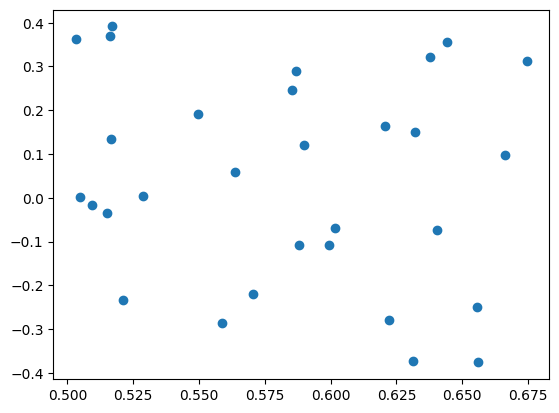

In [15]:
# save the data
np.savez("pushing_trajecotries.npz", tractories=tractories)

# print the success in the pushing
success = 0
for traj in tractories:
    if traj["success"]:
        success += 1
print("Success rate: ", success/len(tractories))

# matplt plot the block position
block_pos = []
for traj in tractories:
    block_pos.append(traj["block_pose"])
block_pos = np.array(block_pos)
plt.scatter(block_pos[:,0], block_pos[:,1])

2. fine-tuning the failure case

In [ ]:
# fine-tune the via-point

In [ ]:
# show all the trainable parameters
for name, param in traj_gen.named_parameters():
    print(f"Parameter: {name}, Size: {param.size()}, Grad: {param.requires_grad}")


In [ ]:
def traj_loss(point, class_idx, x0, goal):
    """
    point: (batch_size, n_dof) -- the via point must get through
    class_idx: (batch_size, ) -- the class of trajectory
    x0: (n_dof) -- the initial state of the trajectory
    goal: (n_dof) -- the goal of the trajectory
    """
    # unsqueeze the point to (batch_size, n_dof, 1)
    point = point.unsqueeze(-1)
    
    if len(point.shape) == 2:
        point = point.unsqueeze(0)

    o_traj = traj_gen.generator(class_idx, x0, goal, d_type="old")
    n_traj = traj_gen.generator(class_idx, x0, goal, d_type="new")
    
    # via point to the trajectory
    p_loss = torch.min(torch.norm(n_traj - point, p=2, dim=1))
    # trajectory shape loss
    s_loss = torch.mean(torch.norm(o_traj - n_traj, p=2, dim=1))
    # end position loss
    e_loss = torch.norm(n_traj[:, :, -1] - goal, p=2, dim=1)
    
    return 0.2*e_loss + 0.2*p_loss + 0.6*s_loss

In [ ]:
# fine-tune the trajectory to path through the via point
robot_inial_pose = torch.tensor(robot_inial_pose, dtype=torch.float32).to(device)
robot_end_pose = torch.tensor(robot_end_pose, dtype=torch.float32).to(device)
via_point = torch.tensor(via_point.T).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, traj_gen.parameters()), lr=0.01)
epoch=500
traj_gen.train()   # in training model
for i in range(epoch):
    optimizer.zero_grad()
    loss = traj_loss(point=via_point, class_idx=2, x0=robot_inial_pose, goal=robot_end_pose)
    loss.backward()
    optimizer.step()

    # print the loss every 100 epoch
    if i % 20 == 0:
        print('epoch: {}, loss: {}'.format(i, loss.item()))

In [ ]:
# plot the fine-tuned trajectory
traj_gen.eval()
with torch.no_grad():
    traj = traj_gen(class_idx=2, x0=robot_inial_pose, goal=robot_end_pose)    
    # plot the generated torque
    new_traj = traj.detach().cpu().numpy()[0]

env.clean_traj_plot()
env.traj_plot(new_traj[:3,:].T)
env.traj_plot(push_data[:3,:].T, color=[1, 0, 0])

In [ ]:
# plot the fine-tuned trajectory in x-z plane by matplotlib
plt.figure()
plt.plot(new_traj[0, :], new_traj[2, :], label="fine-tuned trajectory")
plt.plot(push_data[0, :], push_data[2, :], label="original trajectory")
plt.legend()
plt.xlabel("x-axis")
plt.ylabel("z-axis")
plt.title("Trajectory in x-z plane")
# plot the via point
via_point = via_point.cpu().numpy()
plt.scatter(via_point[0], via_point[2], color='r', label="via point")
# plot the final position
plt.scatter(final_position[0], final_position[2], color='g', label="final position")
